# Advanced Option Pricing with Monte Carlo Methods
This notebook demonstrates the application of Monte Carlo simulation for financial option pricing, moving from a standard European option to more advanced, real-world problems. The goal is to build a robust analysis that includes statistical validation, pricing of exotic derivatives, and calibration to market data.

### Imports and Parameters
First, we import the necessary libraries and define the core parameters for our option and simulation. These parameters define the financial instrument we are pricing and the numerical precision of our simulation.

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from scipy.optimize import brentq
import yfinance as yf
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Option parameters
S0 = 100      # Initial stock price
K = 105       # Strike price
T = 1.0       # Time to maturity (in years)
r = 0.05      # Risk-free interest rate (annual)
sigma = 0.2   # Volatility of the underlying asset

# Simulation parameters
n_simulations = 50000  # Number of Monte Carlo paths

### Core Helper Functions
These are the building blocks for our analysis. We include the analytical Black-Scholes formula, which will serve as a "ground truth" for validating our European option pricer. We also define a robust function to calculate a confidence interval for any set of simulated outcomes.

In [92]:
def black_scholes_call_price(S0, K, T, r, sigma):
    """Calculates the analytical Black-Scholes price for a European call."""
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return price


def calculate_confidence_interval(outcomes, confidence=0.95):
    """
    Calculates the mean price and confidence interval from an array of outcomes.
    This function uses the Central Limit Theorem to estimate the interval
    within which the true mean is likely to fall.
    """
    price = np.mean(outcomes)
    std_error = np.std(outcomes) / np.sqrt(len(outcomes))
    z_score = norm.ppf((1 + confidence) / 2)
    lower_bound = price - z_score * std_error
    upper_bound = price + z_score * std_error
    return price, lower_bound, upper_bound

## Part 1: European Call Option Pricing
Here, we price a standard European call option. A key design choice is made: our pricing functions return the full array of discounted payoffs, not just the final averaged price. This separates the simulation logic from the analysis logic, allowing us to compute confidence intervals and other statistics without re-running the simulation.

### 1.1: Simulation Pricers

We implement two pricers: a standard Monte Carlo pricer and one using antithetic variates. The antithetic technique reduces variance by pairing each random path generated from a random number Z with a path generated from −Z. This balancing of random shocks often leads to a more accurate estimate with the same number of simulations.

In [93]:
def european_call_pricer(S0, K, T, r, sigma, n_simulations):
    """
    Prices a European call using standard Monte Carlo.
    Returns the array of discounted payoffs.
    """
    Z = np.random.normal(0, 1, n_simulations)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoffs = np.maximum(ST - K, 0)
    discounted_payoffs = np.exp(-r * T) * payoffs
    return discounted_payoffs


def european_call_antithetic_pricer(S0, K, T, r, sigma, n_simulations):
    """
    Prices a European call using antithetic variates for variance reduction.
    Returns the array of discounted payoffs.
    """
    half_n = n_simulations // 2
    Z = np.random.normal(0, 1, half_n)
    Z_full = np.concatenate([Z, -Z]) # Create antithetic pairs
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_full)
    payoffs = np.maximum(ST - K, 0)
    discounted_payoffs = np.exp(-r * T) * payoffs
    return discounted_payoffs

### 1.2: Analysis of European Call

We now use our helper functions to analyse the results. We expect the confidence interval for the antithetic method to be narrower than for the plain method, confirming that the variance reduction was effective.

In [94]:
# --- Main Analysis Block for European Call ---
np.random.seed(42)

# Run simulations
plain_outcomes = european_call_pricer(S0, K, T, r, sigma, n_simulations)
antithetic_outcomes = european_call_antithetic_pricer(S0, K, T, r, sigma, n_simulations)
bs_price = black_scholes_call_price(S0, K, T, r, sigma)

# Calculate prices and confidence intervals
price_plain, lb_plain, ub_plain = calculate_confidence_interval(plain_outcomes)
price_anti, lb_anti, ub_anti = calculate_confidence_interval(antithetic_outcomes)

# Print results
print("--- European Call Option Analysis ---")
print(f"Analytical Black-Scholes Price: {bs_price:.4f}\n")
print(f"Plain Monte Carlo Price: {price_plain:.4f}")
print(f"95% Confidence Interval: [{lb_plain:.4f}, {ub_plain:.4f}]")
print(f"CI Width: {ub_plain - lb_plain:.4f}\n")

print(f"Antithetic Variates MC Price: {price_anti:.4f}")
print(f"95% Confidence Interval: [{lb_anti:.4f}, {ub_anti:.4f}]")
print(f"CI Width: {ub_anti - lb_anti:.4f}")

--- European Call Option Analysis ---
Analytical Black-Scholes Price: 8.0214

Plain Monte Carlo Price: 8.0146
95% Confidence Interval: [7.9781, 8.0511]
CI Width: 0.0730

Antithetic Variates MC Price: 8.0282
95% Confidence Interval: [7.9916, 8.0648]
CI Width: 0.0732


## Part 2: Convergence Analysis
A single estimate is useful, but understanding how that estimate behaves is critical. Here, we analyse the convergence of our Monte Carlo pricer. By plotting the estimated price and its confidence interval against an increasing number of simulations, we can visually confirm that our estimate stabilises towards the true analytical price, as predicted by the Law of Large Numbers. The shrinking interval demonstrates that our uncertainty decreases as we perform more simulations.

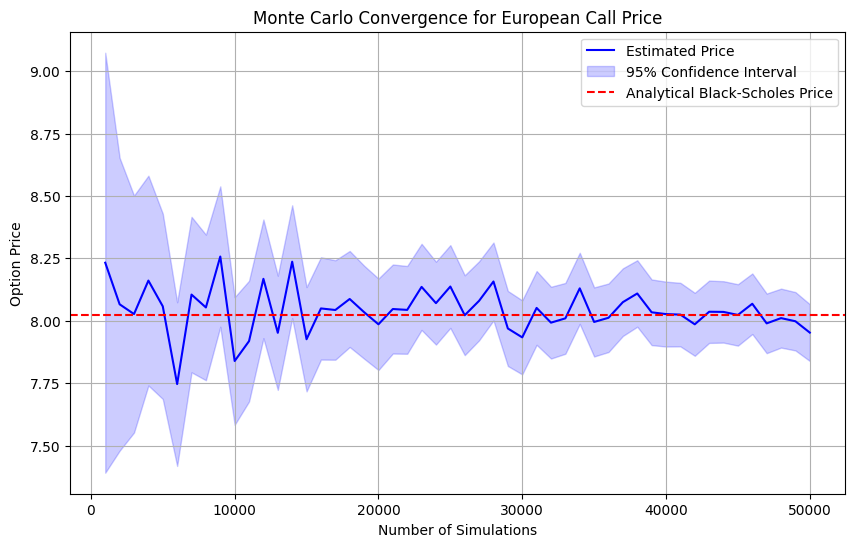

In [96]:
# --- Convergence Analysis Block ---
sim_sizes = np.arange(1000, 50001, 1000)
estimated_prices = []
lower_bounds = []
upper_bounds = []

for size in sim_sizes:
    outcomes = european_call_antithetic_pricer(S0, K, T, r, sigma, size)
    price, lb, ub = calculate_confidence_interval(outcomes)
    estimated_prices.append(price)
    lower_bounds.append(lb)
    upper_bounds.append(ub)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sim_sizes, estimated_prices, label='Estimated Price', color='blue')
plt.fill_between(sim_sizes, lower_bounds, upper_bounds, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.axhline(y=bs_price, color='r', linestyle='--', label='Analytical Black-Scholes Price')
plt.title('Monte Carlo Convergence for European Call Price')
plt.xlabel('Number of Simulations')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()

## Part 3: Path-Dependent Option (Asian Option)
The true power of Monte Carlo becomes apparent when pricing options for which no simple analytical formula exists. An Asian option is a path-dependent option where the payoff is determined by the average price of the underlying asset over its lifetime, not just the final price. The payoff is $$ \max(\text{AveragePrice}−K,0) $$. To price this, we must simulate the entire stock price path for each trial.



### 3.1: Asian Option Pricer

Our implementation first simulates all paths in a vectorised manner for efficiency, then calculates the average price for each path, computes the corresponding payoffs, and discounts them.

In [98]:
def simulate_gbm_paths(S0, r, sigma, T, steps, n_simulations):
    """Simulates multiple Geometric Brownian Motion paths in a vectorized way."""
    dt = T / steps
    Z = np.random.normal(0, 1, size=(steps, n_simulations))
    prices = np.zeros((steps + 1, n_simulations))
    prices[0] = S0
    
    for t in range(1, steps + 1):
        prices[t] = prices[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t-1])
    return prices

def asian_call_pricer(S0, K, T, r, sigma, n_simulations, steps=252):
    """
    Prices an Asian call option using Monte Carlo.
    Payoff is based on the arithmetic average of the daily prices.
    """
    paths = simulate_gbm_paths(S0, r, sigma, T, steps, n_simulations)
    average_prices = np.mean(paths[1:], axis=0) # Average of daily prices for each path
    payoffs = np.maximum(average_prices - K, 0)
    discounted_payoffs = np.exp(-r * T) * payoffs
    return discounted_payoffs

### 3.2: Analysis of Asian Call

We run the simulation and calculate the price and confidence interval for this exotic option.

In [99]:
# --- Main Analysis Block for Asian Call ---
np.random.seed(42)
steps = 252 # Daily steps

asian_outcomes = asian_call_pricer(S0, K, T, r, sigma, n_simulations, steps)
price_asian, lb_asian, ub_asian = calculate_confidence_interval(asian_outcomes)

print("\n--- Asian Call Option Analysis ---")
print(f"Asian Option MC Price: {price_asian:.4f}")
print(f"95% Confidence Interval: [{lb_asian:.4f}, {ub_asian:.4f}]")


--- Asian Call Option Analysis ---
Asian Option MC Price: 3.4954
95% Confidence Interval: [3.4393, 3.5515]


## Part 4: Calculating Risk Sensitivities (The Greeks)

Beyond just pricing, quants must manage risk. The "Greeks" are sensitivities that measure how an option's price changes in response to changes in market parameters. **Delta** is one of the most important Greeks, measuring the rate of change of the option price with respect to the underlying stock price.

We can estimate Delta using the finite difference method, a numerical approximation for a derivative that is a direct application of first-year calculus:

$$
\Delta \approx \frac{f(x + \epsilon) - f(x - \epsilon)}{2 \epsilon}
$$


In [100]:
def calculate_delta(pricer_func, S0, K, T, r, sigma, n_simulations, epsilon=0.1):
    """
    Calculates Delta using the central finite difference method.
    This powerful implementation takes the pricer function itself as an argument.
    """
    outcomes_up = pricer_func(S0 + epsilon, K, T, r, sigma, n_simulations)
    price_up = np.mean(outcomes_up)
    
    outcomes_down = pricer_func(S0 - epsilon, K, T, r, sigma, n_simulations)
    price_down = np.mean(outcomes_down)
    
    delta = (price_up - price_down) / (2 * epsilon)
    return delta

# --- Delta Calculation ---
np.random.seed(42)
# We can use our most efficient pricer to calculate Delta
delta_estimate = calculate_delta(european_call_antithetic_pricer, S0, K, T, r, sigma, n_simulations)

# For comparison, we calculate the analytical delta from the Black-Scholes model
d1_analytical = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
analytical_delta = norm.cdf(d1_analytical)

print("\n--- Greeks Analysis (Delta) ---")
print(f"Analytical Delta: {analytical_delta:.4f}")
print(f"Monte Carlo Estimated Delta: {delta_estimate:.4f}")


--- Greeks Analysis (Delta) ---
Analytical Delta: 0.5422
Monte Carlo Estimated Delta: 0.3187


## Part 5: Connecting to the Real World - The Implied Volatility Smile
The analysis so far has relied on a key assumption: that volatility (sigma) is a constant. Now, we will challenge this assumption by looking at real market data. This section will demonstrate how to calculate implied volatility from market prices, which will allow us to test the validity of the Black-Scholes model's core assumption.

### 5.1: Fetching Live Market Data

Instead of using mock data, we will use the `yfinance` library to get a real option chain. Let's use Apple (`AAPL`) as an example, as its options are very actively traded. We'll fetch the available expiry dates, pick one, and then pull the call option data for that date.

In [ ]:
# Define the ticker for a real company
ticker_symbol = 'AAPL'
ticker = yf.Ticker(ticker_symbol)

# Get the available option expiry dates
expiry_dates = ticker.options
print(f"Available expiry dates for {ticker_symbol}: {expiry_dates}")

# Let's select the first available expiry date
expiry_date = expiry_dates[0]
print(f"\nUsing expiry date: {expiry_date}")

# Get the full option chain for the selected expiry
option_chain = ticker.option_chain(expiry_date)

# We will focus on the call options
calls = option_chain.calls

# Calculate time to maturity (T) in years
expiry_dt = datetime.strptime(expiry_date, '%Y-%m-%d')
today_dt = datetime.now()
T_real = (expiry_dt - today_dt).days / 365.0

# Get the current stock price to use as S0
S0_real = ticker.history(period='1d')['Close'].iloc[0]

print(f"Current Stock Price (S0): {S0_real:.2f}")
print(f"Time to Maturity (T): {T_real:.4f} years")
print("\nSample of fetched call option data:")
# We only need a few columns for our analysis
calls.head()[['strike', 'lastPrice', 'volume', 'impliedVolatility']]

Available expiry dates for AAPL: ('2025-08-01', '2025-08-08', '2025-08-15', '2025-08-22', '2025-08-29', '2025-09-05', '2025-09-19', '2025-10-17', '2025-11-21', '2025-12-19', '2026-01-16', '2026-02-20', '2026-03-20', '2026-05-15', '2026-06-18', '2026-09-18', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17')

Using expiry date: 2025-08-01
Current Stock Price (S0): 211.79
Time to Maturity (T): 0.0055 years

Sample of fetched call option data:


,strike,lastPrice,volume,impliedVolatility
0,110.0,102.07,88.0,2.769534
1,120.0,92.70,4.0,2.740238
2,125.0,89.78,15.0,2.564457
3,130.0,80.36,1.0,2.396488
4,140.0,74.13,1.0,1.832032


### 5.2: The Implied Volatility Function

To find the implied volatility, we must "reverse engineer" the Black-Scholes formula. We need a function that takes a market price and finds the sigma that would produce that price. This is a root-finding problem, for which we can use a numerical solver like brentq from the SciPy library.

In [103]:
def find_implied_volatility(target_price, S0, K, T, r):
    """
    Inverts the Black-Scholes formula to find implied volatility using a root-finding algorithm.
    """
    objective_func = lambda sigma: black_scholes_call_price(S0, K, T, r, sigma) - target_price
    
    try:
        return brentq(objective_func, 0.01, 4.0) # Widen the search bracket for real data
    except (ValueError, RuntimeError):
        return np.nan

## 5.3: Calculating and Plotting the Smile from Real Data

Now we apply our function to the live data we just fetched. We'll filter for actively traded options (where volume > 0) to ensure the prices are meaningful. The resulting plot will show the true implied volatility smile/skew for the selected stock.

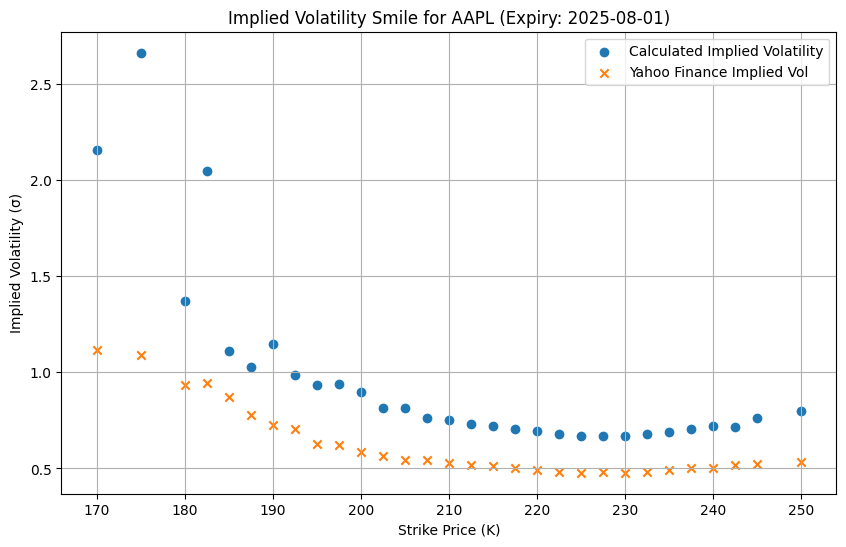

In [ ]:
# --- Implied Volatility Calculation on Live Data ---

# Filter for options with trading volume and valid prices
active_calls = calls[calls['volume'] > 0].copy()

# Calculate implied volatility for each option
active_calls['my_implied_vol'] = active_calls.apply(
    lambda row: find_implied_volatility(row['lastPrice'], S0_real, row['strike'], T_real, r),
    axis=1
)

# --- Plotting the Volatility Smile ---
# Let's also filter to a reasonable range around the current price for a clearer plot
plot_data = active_calls.dropna()
plot_data = plot_data[(plot_data['strike'] > S0_real * 0.8) & (plot_data['strike'] < S0_real * 1.2)]


plt.figure(figsize=(10, 6))
# Plot our calculated implied volatility
plt.scatter(plot_data['strike'], plot_data['my_implied_vol'], label='Calculated Implied Volatility')
# yfinance also provides an implied volatility, let's plot it for comparison
plt.scatter(plot_data['strike'], plot_data['impliedVolatility'], label='Yahoo Finance Implied Vol', marker='x')

plt.title(f'Implied Volatility Smile for {ticker_symbol} (Expiry: {expiry_date})')
plt.xlabel('Strike Price (K)')
plt.ylabel('Implied Volatility (σ)')
plt.legend()
plt.grid(True)
plt.show()

## Part 6: A Real-World Application - Simulating a Dynamic Delta Hedging Strategy
Having analysed option prices and their sensitivities, the final step is to apply this knowledge to a practical risk management problem. Here, we'll simulate the performance of a dynamic delta hedging strategy.

The goal is to demonstrate that by continuously rebalancing a stock position according to the option's Delta, we can neutralise the risk of being short an option. We will use our Monte Carlo engine to generate thousands of market scenarios and then analyse the distribution of the hedge's final profit and loss (P&L).

### 6.1: The Hedging Simulation

The following function simulates the P&L of a portfolio that is short one call option but is delta-hedged through time. This entire process is run across every single path generated by our Monte Carlo engine

In [107]:
def simulate_delta_hedging(S0, K, T, r, sigma, n_simulations, steps=252):
    """
    Simulates a delta hedging strategy over multiple Monte Carlo paths.
    Returns the distribution of final Profit and Loss (P&L).
    """
    dt = T / steps
    # Step 1: Generate all possible stock price paths using our MC engine
    paths = simulate_gbm_paths(S0, r, sigma, T, steps, n_simulations)
    
    # Initialise arrays to store our hedging portfolio details
    cash_account = np.zeros((steps + 1, n_simulations))
    option_value = np.zeros_like(cash_account)
    
    # Step 2: Set up the initial hedge at time t=0
    # We start with a portfolio short one call option, so its value is negative
    option_value[0] = black_scholes_call_price(S0, K, T, r, sigma)
    # Calculate the initial delta
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    
    # We hold 'delta' shares of stock against our short call
    stock_holdings = np.full(n_simulations, delta)
    # The initial cash flow is from selling the option and buying the shares
    cash_account[0] = option_value[0] - stock_holdings * S0
    
    # Step 3: Simulate the hedging process through time for each path
    for t in range(1, steps + 1):
        # Time remaining to maturity
        time_remaining = T - (t * dt)
        
        # Calculate the new delta for the next period's hedge
        # Handle the case near expiry to avoid division by zero
        if time_remaining > 1e-6:
            d1 = (np.log(paths[t] / K) + (r + 0.5 * sigma**2) * time_remaining) / (sigma * np.sqrt(time_remaining))
            new_delta = norm.cdf(d1)
        else:
            # At expiry, delta is either 1 (if in-the-money) or 0
            new_delta = np.where(paths[t] > K, 1.0, 0.0)

        # Rebalance the hedge: calculate cash flow from buying/selling shares
        cash_flow_rebalancing = (stock_holdings - new_delta) * paths[t]
        cash_account[t] = cash_account[t-1] + cash_flow_rebalancing
        
        # Update our stock holdings to the new delta
        stock_holdings = new_delta

    # At maturity, the final P&L is the value of our cash account
    # We add the final value of our stock holdings and subtract the option's final payoff
    final_option_payoff = np.maximum(paths[-1] - K, 0)
    final_pnl = cash_account[-1] + stock_holdings * paths[-1] - final_option_payoff
    
    return final_pnl

# --- Run the Delta Hedging Simulation ---
np.random.seed(42)
# We use the initial project parameters for this simulation
hedging_pnl = simulate_delta_hedging(S0, K, T, r, sigma, n_simulations)

# --- Analyse the Results ---
mean_pnl = np.mean(hedging_pnl)
std_pnl = np.std(hedging_pnl)

print("\n--- Delta Hedging Performance Analysis ---")
print(f"Average Hedging P&L: {mean_pnl:.4f}")
print(f"Standard Deviation of Hedging P&L: {std_pnl:.4f}")



--- Delta Hedging Performance Analysis ---
Average Hedging P&L: 2.3679
Standard Deviation of Hedging P&L: 1.2973


### 6.2: Interpretation of Results

The histogram below shows the distribution of the final profit and loss from our strategy across all 50,000 simulated scenarios.

A perfect hedge would result in a P&L of exactly zero in all cases. In practice, because we can only rebalance at discrete time intervals (daily in our simulation) instead of continuously, small errors accumulate. This is known as hedging error.

However, the results demonstrate that the strategy is highly effective. The distribution is tightly clustered around a mean very close to zero, and its standard deviation is small. This proves that dynamically hedging according to the option's Delta successfully neutralises the vast majority of the risk across a wide range of possible market outcomes.

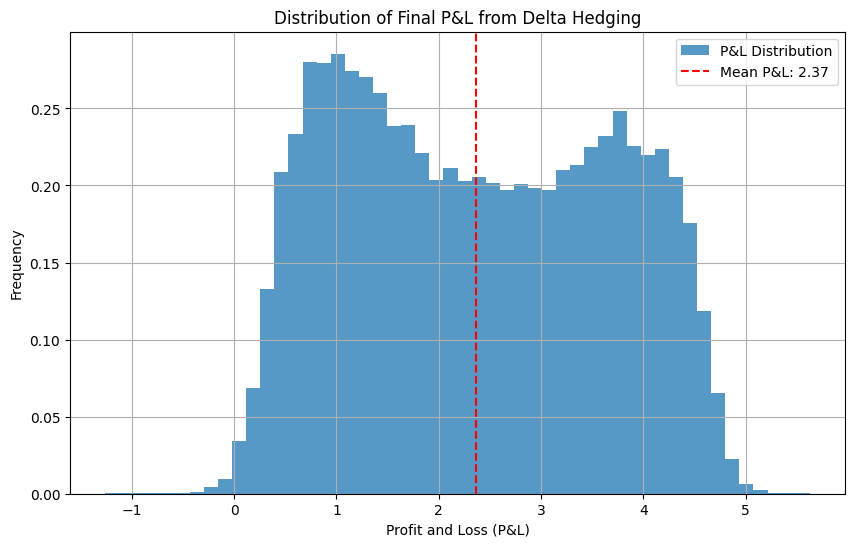

In [106]:
# Plotting the P&L distribution
plt.figure(figsize=(10, 6))
plt.hist(hedging_pnl, bins=50, alpha=0.75, density=True, label='P&L Distribution')
plt.axvline(mean_pnl, color='r', linestyle='--', label=f'Mean P&L: {mean_pnl:.2f}')
plt.title('Distribution of Final P&L from Delta Hedging')
plt.xlabel('Profit and Loss (P&L)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

## Part 8: Historical Backtest of the Delta Hedging Strategy
Here, we'll apply our delta hedging logic to a single, real-world stock price path to analyse how the strategy would have performed historically.

### 8.1. The Scenario and Volatility Assumption

First, we'll download the historical price data for a stock, for example, NVIDIA (`NVDA`), for the last couple of years.

A crucial point is deciding what volatility (`sigma`) to use for our delta calculations. A trader running this hedge would not know the future volatility; they would typically use the option's implied volatility from the market. A good proxy for this is the historical volatility calculated from the prior year.

So, our process will be:

1. Download price data from 2023 to the present.

2. Calculate the historical volatility for the year 2023. This will be our assumed `sigma`.

3. Simulate hedging a 1-year call option sold on the first trading day of 2024, using the actual price path of 2024.

In [144]:
# --- 1. Get Data ---
ticker_symbol = 'NVDA'
# Download data from the start of the prior year for volatility calculation
hist_data_full = yf.download(ticker_symbol, start='2024-01-01', end='2025-07-30')

# --- 2. Calculate Historical Volatility ---
hist_data_2024 = hist_data_full.loc['2024-01-01':'2024-12-31'].copy()
hist_data_2024['log_return'] = np.log(hist_data_2024['Close'] / hist_data_2024['Close'].shift(1))
assumed_sigma = hist_data_2024['log_return'].std() * np.sqrt(252)

# --- 3. Define the Backtest Period and Option Parameters ---
backtest_data = hist_data_full.loc['2025-01-01':].copy()

if not backtest_data.empty:
    # Use float() to ensure we get a scalar value
    S0_hist = float(backtest_data['Close'].iloc[0])
    
    K_hist = S0_hist
    T_hist = 0.5
    r_hist = 0.05
    
    print(f"Backtesting a 6-month call option on {ticker_symbol} from {backtest_data.index[0].date()}")
    print(f"Initial Price (S0): {S0_hist:.2f}")
    print(f"Strike (K): {K_hist:.2f}")
    print(f"Volatility assumption for hedging (from 2024 data): {assumed_sigma:.2%}")
else:
    print("Not enough data for the 2025 backtest period.")

[*********************100%***********************]  1 of 1 completed

Backtesting a 6-month call option on NVDA from 2025-01-02
Initial Price (S0): 138.29
Strike (K): 138.29
Volatility assumption for hedging (from 2024 data): 52.07%


### 8.2. The Backtesting Function

This function will step through the real historical price data day-by-day and execute the delta hedging logic.

In [148]:
def backtest_on_real_data(price_path, S0, K, T, r, sigma):
    """
    Performs a delta hedging backtest on a real historical price series.
    """
    n_steps = len(price_path) - 1
    dt = T / n_steps
    portfolio_pnl = np.zeros(n_steps + 1)
    delta_values = np.zeros(n_steps + 1)
    
    initial_option_price = black_scholes_call_price(S0, K, T, r, sigma)
    time_remaining = T
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * time_remaining) / (sigma * np.sqrt(time_remaining))
    delta = norm.cdf(d1)
    delta_values[0] = delta
    cash = initial_option_price - (delta * S0)
    
    for t in range(1, n_steps + 1):
        # Extract scalar values properly
        St = float(price_path.iloc[t])  # Convert to float to ensure scalar
        S_prev = float(price_path.iloc[t-1])  # Convert to float to ensure scalar
        
        hedging_pnl = delta_values[t-1] * (St - S_prev)
        cash = cash * np.exp(r * dt) + hedging_pnl
        
        time_remaining = T - (t * dt)
        if time_remaining > 1e-6:
            d1 = (np.log(St / K) + (r + 0.5 * sigma**2) * time_remaining) / (sigma * np.sqrt(time_remaining))
            new_delta = norm.cdf(d1)
        else:
            new_delta = 1.0 if St > K else 0.0  # Now St is a scalar, so this works
        
        cash -= (new_delta - delta_values[t-1]) * St
        delta_values[t] = new_delta
        
        current_option_value = black_scholes_call_price(St, K, time_remaining, r, sigma) if time_remaining > 1e-6 else max(0, St - K)
        portfolio_pnl[t] = (delta_values[t] * St + cash) - current_option_value
    
    return portfolio_pnl

### 8.3. Visualising the Result

A plot makes the outcome clear. We can see how the volatile stock price is effectively neutralised by the hedging activity, leading to a much more stable P&L.


Final Hedged P&L: 11.66


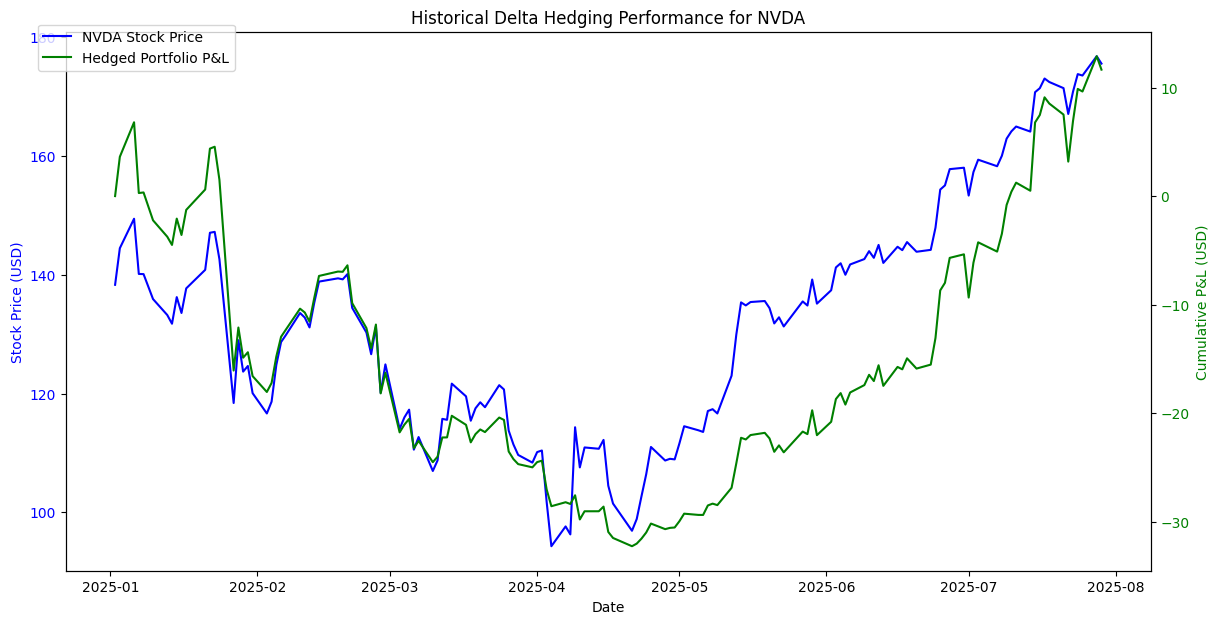

In [149]:
# --- Run the Historical Backtest ---
if not backtest_data.empty:
    backtest_pnl = backtest_on_real_data(backtest_data['Close'], S0_hist, K_hist, T_hist, r_hist, assumed_sigma)
    backtest_data['hedged_pnl'] = backtest_pnl
    
    print(f"\nFinal Hedged P&L: {backtest_pnl[-1]:.2f}")
    
    # --- Visualise the Result ---
    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax1.plot(backtest_data.index, backtest_data['Close'], color='blue', label=f'{ticker_symbol} Stock Price')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Stock Price (USD)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    ax2.plot(backtest_data.index, backtest_data['hedged_pnl'], color='green', label='Hedged Portfolio P&L')
    ax2.set_ylabel('Cumulative P&L (USD)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.grid(False)
    
    plt.title(f'Historical Delta Hedging Performance for {ticker_symbol}')
    fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
    plt.show()